<a href="https://colab.research.google.com/github/serivan/DeepLearning/blob/master/Keras/15_processing_sequences_using_rnns_and_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chapter 15 – Processing Sequences Using RNNs and CNNs**

_This notebook contains all the sample code in chapter 15._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [3]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


# Basic RNNs

### Generate the Dataset

In [4]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [5]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [6]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


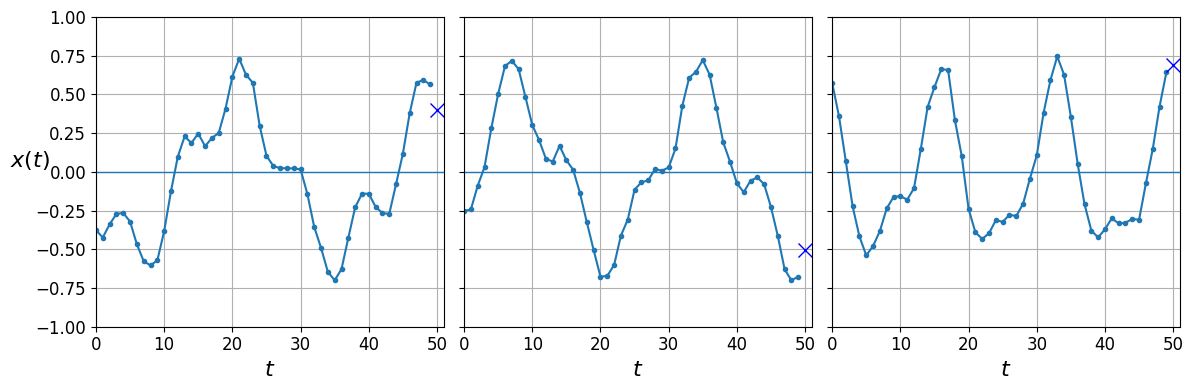

In [7]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

### Computing Some Baselines

Naive predictions (just predict the last observed value):

In [8]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.MSE(y_valid, y_pred))

0.020211367

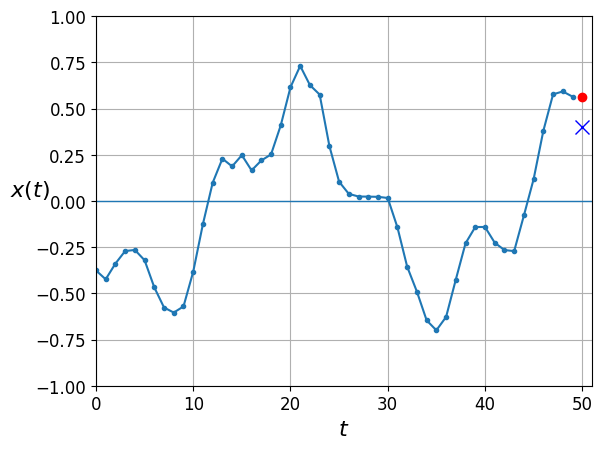

In [9]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Linear predictions:

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1948 - val_loss: 0.0673
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0577 - val_loss: 0.0356
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0316 - val_loss: 0.0219
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0198 - val_loss: 0.0154
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0142 - val_loss: 0.0122
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0114 - val_loss: 0.0104
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0098 - val_loss: 0.0092
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0086 - val_loss: 0.0082
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0077 - val_loss: 0.0073
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - val_loss: 0.0067
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste

In [11]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0041


0.004184816498309374

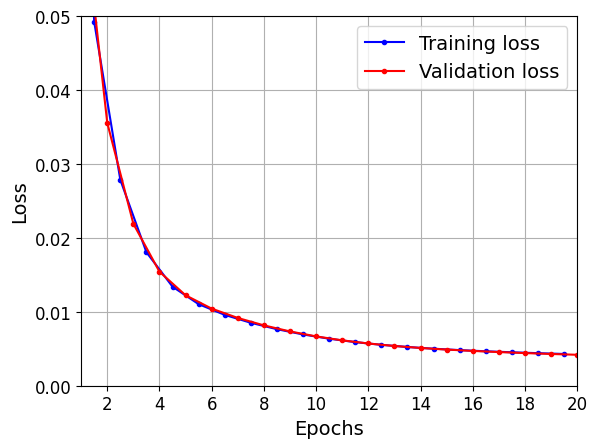

In [12]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


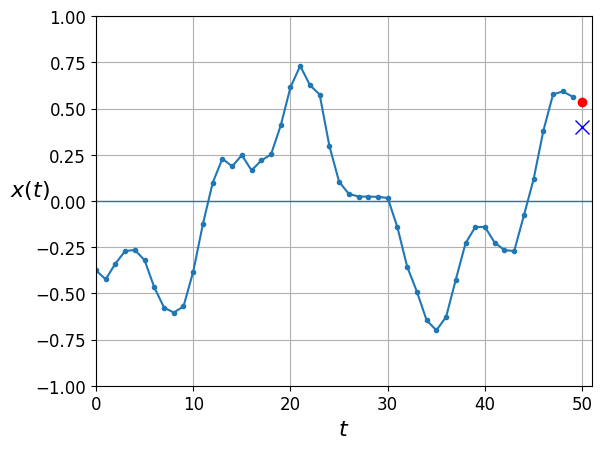

In [13]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0139 - val_loss: 0.0109
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

In [15]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110


0.010957497172057629

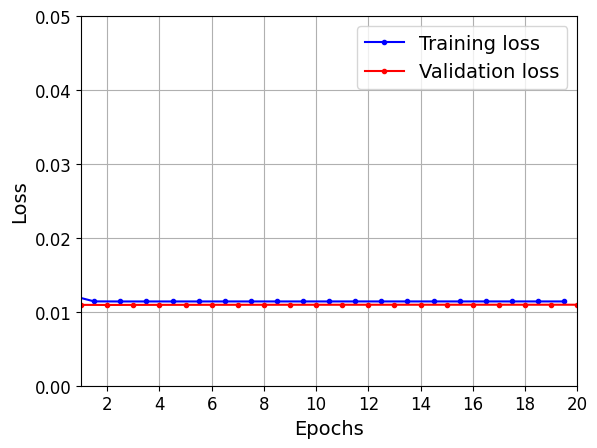

In [16]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


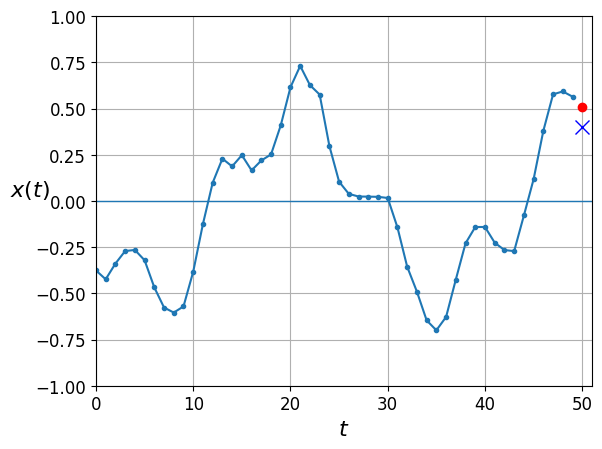

In [17]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [18]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.0948 - val_loss: 0.0059
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0049 - val_loss: 0.0037
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 

In [19]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023


0.0023976049851626158

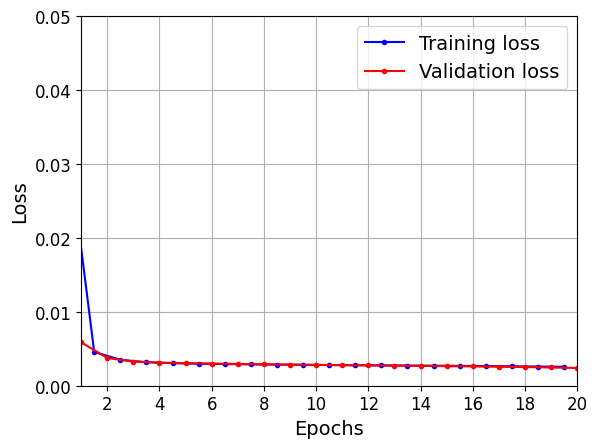

In [20]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


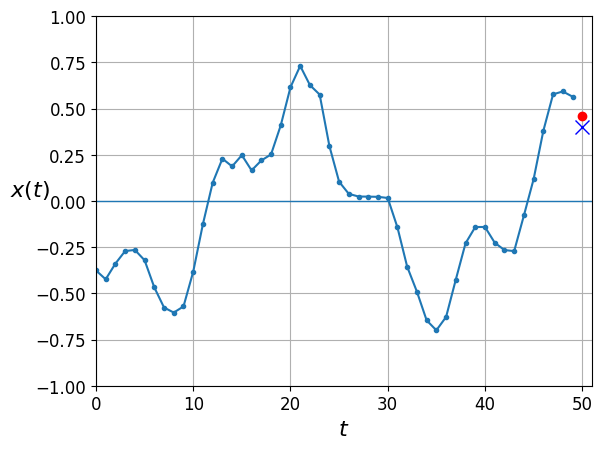

In [21]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Make the second `SimpleRNN` layer return only the last output:

In [22]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.1034 - val_loss: 0.0063
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0054 - val_loss: 0.0043
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 

In [23]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027


0.0028847723733633757

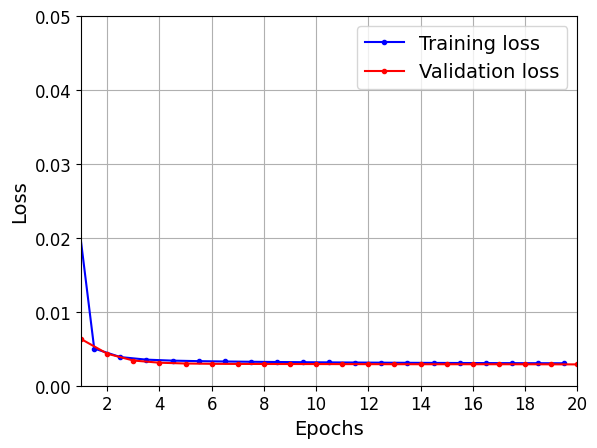

In [24]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


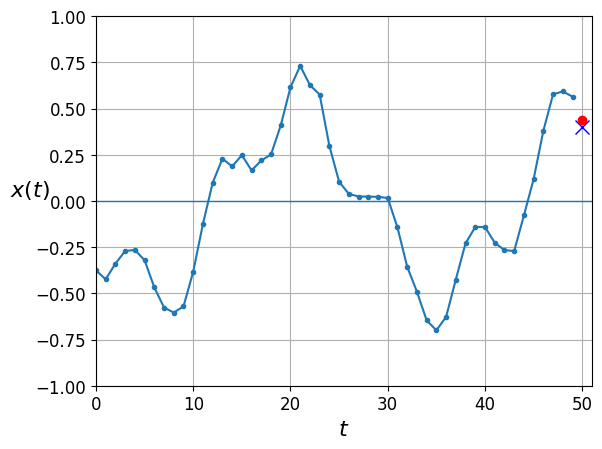

In [25]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

In [26]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [27]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


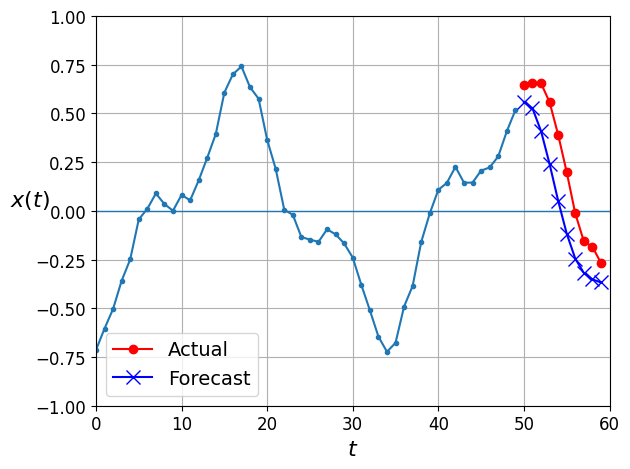

In [28]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [29]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [30]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [31]:
Y_pred.shape

(2000, 10)

In [32]:
np.mean(keras.metrics.MSE(Y_valid, Y_pred))

0.035679173

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [33]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.MSE(Y_valid, Y_naive_pred))

0.22278848

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

model_seq = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model_seq.compile(loss="mse", optimizer="adam")
history = model_seq.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2196 - val_loss: 0.0727
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0625 - val_loss: 0.0452
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0422 - val_loss: 0.0357
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0344 - val_loss: 0.0311
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0304 - val_loss: 0.0284
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0279 - val_loss: 0.0266
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0262 - val_loss: 0.0253
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0250 - val_loss: 0.0243
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0240 - val_loss: 0.0235
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0232 - val_loss: 0.0228
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0225 - val_loss: 0.0222
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [35]:
model_seq.evaluate(X_test, Y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0198


0.019863475114107132

Now let's create an RNN that predicts all 10 next values at once:

In [36]:
np.random.seed(42)
tf.random.set_seed(42)

model_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model_rnn.compile(loss="mse", optimizer="adam")
history = model_rnn.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.1025 - val_loss: 0.0321
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0280 - val_loss: 0.0190
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0179 - val_loss: 0.0161
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0147 - val_loss: 0.0136
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0130 - val_loss: 0.0123
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0120 - val_loss: 0.0117
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0114 - val_loss: 0.0113
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0109 - val_loss: 0.0111
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0105 - val_loss: 0.0110
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0102 - val_loss: 0.0108
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0099 - val_loss: 0.0108
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 

In [37]:
model_rnn.evaluate(X_test, Y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0089


0.008620034903287888

In [46]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model_rnn.predict(X_new)[..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


In [45]:
YY= model.predict(X_new)
YY

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


array([[0.55855024]], dtype=float32)

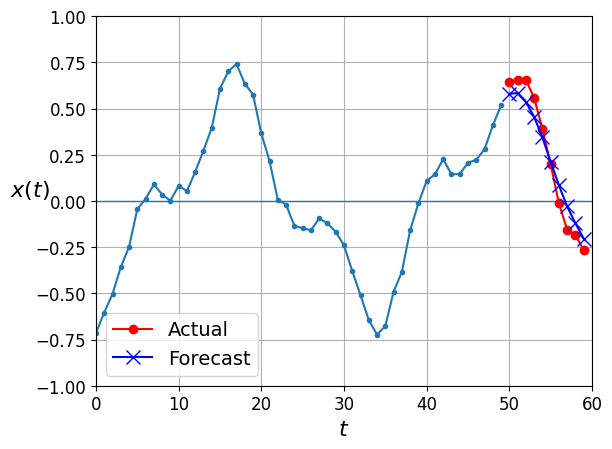

In [47]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [48]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [49]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [50]:
np.random.seed(42)
tf.random.set_seed(42)

model_td = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.MSE(Y_true[:, -1], Y_pred[:, -1])

model_td.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model_td.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - last_time_step_mse: 0.0641 - loss: 0.0716 - val_last_time_step_mse: 0.0306 - val_loss: 0.0416
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - last_time_step_mse: 0.0302 - loss: 0.0408 - val_last_time_step_mse: 0.0204 - val_loss: 0.0329
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0216 - loss: 0.0335 - val_last_time_step_mse: 0.0180 - val_loss: 0.0299
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - last_time_step_mse: 0.0183 - loss: 0.0298 - val_last_time_step_mse: 0.0158 - val_loss: 0.0275
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0161 - loss: 0.0275 - val_last_time_step_mse: 0.0123 - val_loss: 0.0241
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - last_time_step_mse: 0.0130 - loss: 0.0249 - val_last_time_step_mse: 0.0109 - val_loss: 0.0239
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - last_time_step_mse: 0.0110 - loss: 0.0233 - val_last_time_ste

In [51]:
model_td.evaluate(X_test, Y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - last_time_step_mse: 0.0072 - loss: 0.0185


[0.018445976078510284, 0.0072319237515330315]

In [52]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model_td.predict(X_new)[:, -1][..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


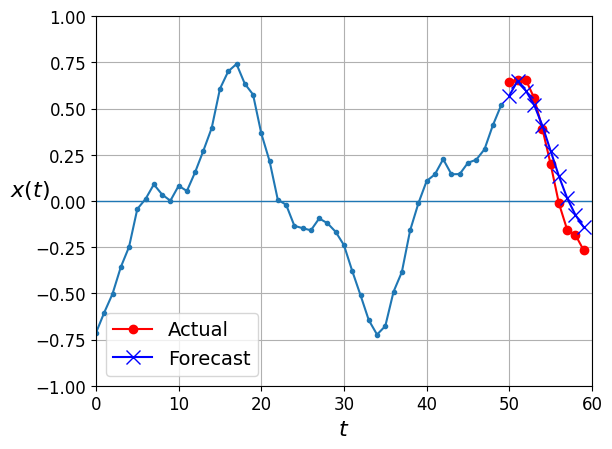

In [53]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Deep RNN with Batch Norm

In [54]:
np.random.seed(42)
tf.random.set_seed(42)

model_bn = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model_bn.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model_bn.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - last_time_step_mse: 0.3024 - loss: 0.2960 - val_last_time_step_mse: 0.0631 - val_loss: 0.0704
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - last_time_step_mse: 0.0428 - loss: 0.0535 - val_last_time_step_mse: 0.0380 - val_loss: 0.0485
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - last_time_step_mse: 0.0358 - loss: 0.0464 - val_last_time_step_mse: 0.0323 - val_loss: 0.0438
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0313 - loss: 0.0423 - val_last_time_step_mse: 0.0295 - val_loss: 0.0411
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0282 - loss: 0.0395 - val_last_time_step_mse: 0.0271 - val_loss: 0.0392
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0257 - loss: 0.0372 - val_last_time_step_mse: 0.0256 - val_loss: 0.0380
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - last_time_step_mse: 0.0237 - loss: 0.0353 - val_la

In [55]:
model_bn.evaluate(X_test, Y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - last_time_step_mse: 0.0167 - loss: 0.0293


[0.029387017711997032, 0.016745135188102722]

# Deep RNNs with Layer Norm

In [56]:
from tensorflow.keras.layers import LayerNormalization

In [57]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [58]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [59]:
np.random.seed(42)
tf.random.set_seed(42)

model_ln = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model_ln.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model_ln.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - last_time_step_mse: 0.3083 - loss: 0.2934 - val_last_time_step_mse: 0.0530 - val_loss: 0.0660
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - last_time_step_mse: 0.0509 - loss: 0.0630 - val_last_time_step_mse: 0.0432 - val_loss: 0.0562
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - last_time_step_mse: 0.0429 - loss: 0.0550 - val_last_time_step_mse: 0.0381 - val_loss: 0.0508
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - last_time_step_mse: 0.0376 - loss: 0.0500 - val_last_time_step_mse: 0.0319 - val_loss: 0.0467
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - last_time_step_mse: 0.0313 - loss: 0.0458 - val_last_time_step_mse: 0.0254 - val_loss: 0.0416
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - last_time_step_mse: 0.0255 - loss: 0.0413 - val_last_time_step_mse: 0.0227 - val_loss: 0.0392
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - last_time_step_mse: 0.0230 - loss: 0.0390 - val_last_time_ste

In [60]:
model_ln.evaluate(X_test, Y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - last_time_step_mse: 0.0120 - loss: 0.0253


[0.025535350665450096, 0.011982312425971031]

# LSTMs

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [61]:
#Already defined; included for an easier reload
#Same as before...
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [62]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.MSE(Y_true[:, -1], Y_pred[:, -1])

In [63]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, None, 20)            │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, None, 20)            │           3,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, None, 10)            │             210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,250 (20.51 KB)

 Trainable params: 5,250 (20.51 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - last_time_step_mse: 0.0899 - loss: 0.1006 - val_last_time_step_mse: 0.0301 - val_loss: 0.0528
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - last_time_step_mse: 0.0267 - loss: 0.0486 - val_last_time_step_mse: 0.0163 - val_loss: 0.0395
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - last_time_step_mse: 0.0161 - loss: 0.0383 - val_last_time_step_mse: 0.0143 - val_loss: 0.0352
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0141 - loss: 0.0346 - val_last_time_step_mse: 0.0136 - val_loss: 0.0329
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - last_time_step_mse: 0.0132 - loss: 0.0324 - val_last_time_step_mse: 0.0130 - val_loss: 0.0313
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - last_time_step_mse: 0.0124 - loss: 0.0308 - val_last_time_step_mse: 0.0124 - val_loss: 0.0300
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - last_time_step_mse: 0.0118 - loss: 0.0296 - val_las

In [65]:
model.evaluate(X_valid, Y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - last_time_step_mse: 0.0087 - loss: 0.0234


[0.023465221747756004, 0.008600793778896332]

In [66]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, None, 20)            │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, None, 20)            │           3,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, None, 10)            │             210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,250 (20.51 KB)

 Trainable params: 5,250 (20.51 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - last_time_step_mse: 0.0960 - loss: 0.1057 - val_last_time_step_mse: 0.0320 - val_loss: 0.0533
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - last_time_step_mse: 0.0280 - loss: 0.0490 - val_last_time_step_mse: 0.0173 - val_loss: 0.0396
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - last_time_step_mse: 0.0167 - loss: 0.0378 - val_last_time_step_mse: 0.0141 - val_loss: 0.0344
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - last_time_step_mse: 0.0142 - loss: 0.0338 - val_last_time_step_mse: 0.0128 - val_loss: 0.0316
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0126 - loss: 0.0313 - val_last_time_step_mse: 0.0121 - val_loss: 0.0299
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - last_time_step_mse: 0.0116 - loss: 0.0296 - val_last_time_step_mse: 0.0117 - val_loss: 0.0287
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - last_time_step_mse: 0.0110 - loss: 0.0285 - val_last_ti

In [68]:
model.evaluate(X_valid, Y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - last_time_step_mse: 0.0087 - loss: 0.0230


[0.023032935336232185, 0.008666248060762882]

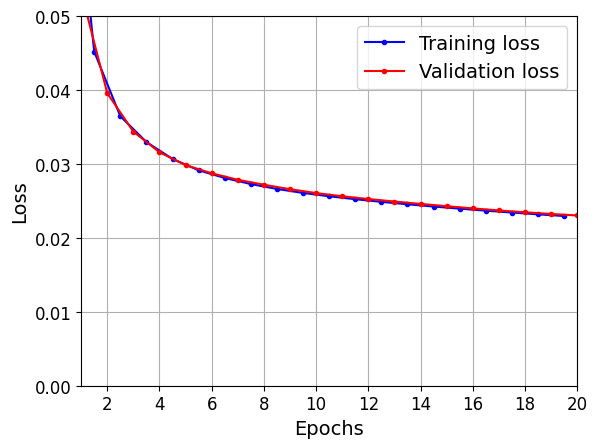

In [69]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [70]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


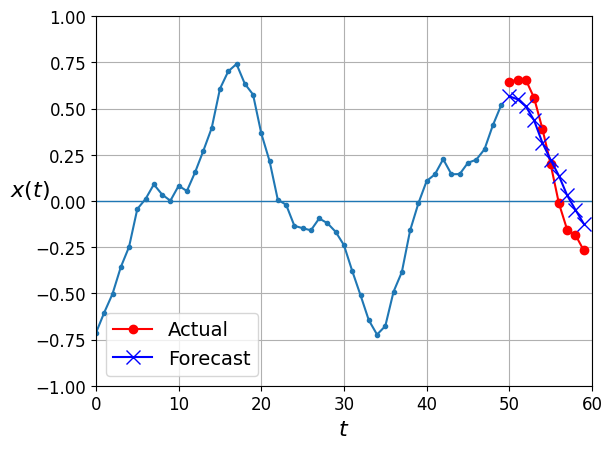

In [71]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRUs

In [72]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, None, 20)            │           1,380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, None, 20)            │           2,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, None, 10)            │             210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,110 (16.05 KB)

 Trainable params: 4,110 (16.05 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:

history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - last_time_step_mse: 0.0940 - loss: 0.1004 - val_last_time_step_mse: 0.0433 - val_loss: 0.0544
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - last_time_step_mse: 0.0409 - loss: 0.0514 - val_last_time_step_mse: 0.0330 - val_loss: 0.0445
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0329 - loss: 0.0436 - val_last_time_step_mse: 0.0276 - val_loss: 0.0397
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - last_time_step_mse: 0.0281 - loss: 0.0391 - val_last_time_step_mse: 0.0215 - val_loss: 0.0352
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - last_time_step_mse: 0.0230 - loss: 0.0345 - val_last_time_step_mse: 0.0171 - val_loss: 0.0320
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - last_time_step_mse: 0.0185 - loss: 0.0315 - val_last_time_step_mse: 0.0142 - val_loss: 0.0297
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0148 - loss: 0.0294 - val_las

In [74]:
model.evaluate(X_valid, Y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - last_time_step_mse: 0.0099 - loss: 0.0238


[0.023849358782172203, 0.009854885749518871]

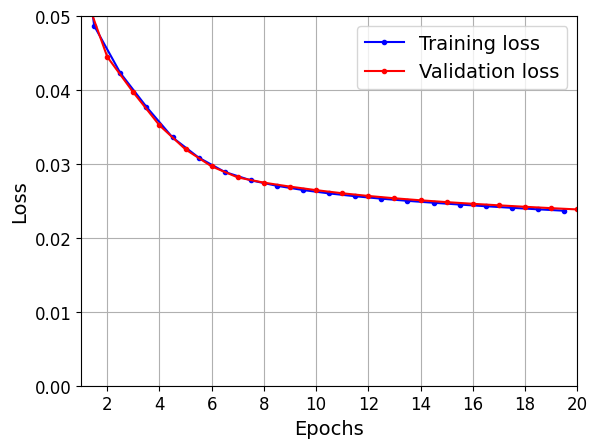

In [75]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [76]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


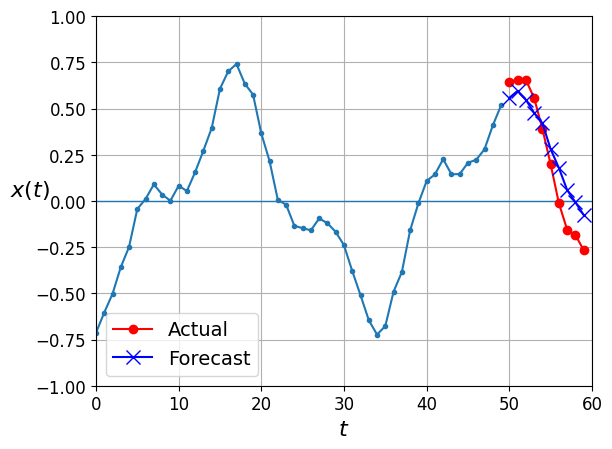

In [77]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Using One-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [78]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - last_time_step_mse: 0.0905 - loss: 0.0971 - val_last_time_step_mse: 0.0418 - val_loss: 0.0500
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - last_time_step_mse: 0.0371 - loss: 0.0445 - val_last_time_step_mse: 0.0254 - val_loss: 0.0342
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - last_time_step_mse: 0.0254 - loss: 0.0331 - val_last_time_step_mse: 0.0192 - val_loss: 0.0290
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0189 - loss: 0.0282 - val_last_time_step_mse: 0.0156 - val_loss: 0.0262
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0155 - loss: 0.0257 - val_last_time_step_mse: 0.0138 - val_loss: 0.0245
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0137 - loss: 0.0242 - val_last_time_step_mse: 0.0126 - val_loss: 0.0234
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0125 - loss: 0.0232 - val_last_time_step_ms

## WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [79]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - last_time_step_mse: 0.0947 - loss: 0.1030 - val_last_time_step_mse: 0.0222 - val_loss: 0.0368
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - last_time_step_mse: 0.0215 - loss: 0.0352 - val_last_time_step_mse: 0.0178 - val_loss: 0.0316
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - last_time_step_mse: 0.0176 - loss: 0.0307 - val_last_time_step_mse: 0.0160 - val_loss: 0.0292
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - last_time_step_mse: 0.0155 - loss: 0.0283 - val_last_time_step_mse: 0.0144 - val_loss: 0.0272
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - last_time_step_mse: 0.0140 - loss: 0.0266 - val_last_time_step_mse: 0.0130 - val_loss: 0.0256
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - last_time_step_mse: 0.0128 - loss: 0.0253 - val_last_time_step_mse: 0.0119 - val_loss: 0.0244
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - last_time_step_mse: 0.0118 - loss: 0.0242 - val_last_time_step_mse:

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [80]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [81]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [82]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [83]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Epoch 1/2
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - last_time_step_mse: 0.1330 - loss: 0.1371 - val_last_time_step_mse: 0.1195 - val_loss: 0.1225
Epoch 2/2
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - last_time_step_mse: 0.1176 - loss: 0.1222 - val_last_time_step_mse: 0.1187 - val_loss: 0.1216


In this chapter we explored the fundamentals of RNNs and used them to process sequences (namely, time series). In the process we also looked at other ways to process sequences, including CNNs. In the next chapter we will use RNNs for Natural Language Processing, and we will learn more about RNNs (bidirectional RNNs, stateful vs stateless RNNs, Encoder–Decoders, and Attention-augmented Encoder-Decoders). We will also look at the Transformer, an Attention-only architecture.

# Exercise solutions

## 1. to 8.

See Appendix A.

## 9. Tackling the SketchRNN Dataset

_Exercise: Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets._

The dataset is not available in TFDS yet, the [pull request](https://github.com/tensorflow/datasets/pull/361) is still work in progress. Luckily, the data is conveniently available as TFRecords, so let's download it (it might take a while, as it's about 1 GB large, with 3,450,000 training sketches and 345,000 test sketches):

In [84]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

1065301781/1065301781 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step


In [85]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [86]:
train_files

['/root/.keras/datasets/quickdraw/training.tfrecord-00000-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00001-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00002-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00003-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00004-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00005-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00006-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00007-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00008-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00009-of-00010']

In [87]:
eval_files

['/root/.keras/datasets/quickdraw/eval.tfrecord-00000-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00001-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00002-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00003-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00004-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00005-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00006-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00007-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00008-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00009-of-00010']

In [88]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()

with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [89]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [90]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [91]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [92]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [93]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [94]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.0944882  -0.04663213  0.        ]
  [-0.08661417  0.04145078  0.        ]
  [-0.03937007  0.05181348  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.04313726 -0.14960629  0.        ]
  [ 0.06274509 -0.40551183  0.        ]
  [ 0.04313726 -0.12598425  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          1.        ]
  [ 0.          0.          0.        ]
  [-0.19607842 -0.03174603  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.12790698  0.01960784  0.        ]
  [-0.02906978  0.2117647   0.        ]
  [-0.04651159  0.06274509  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

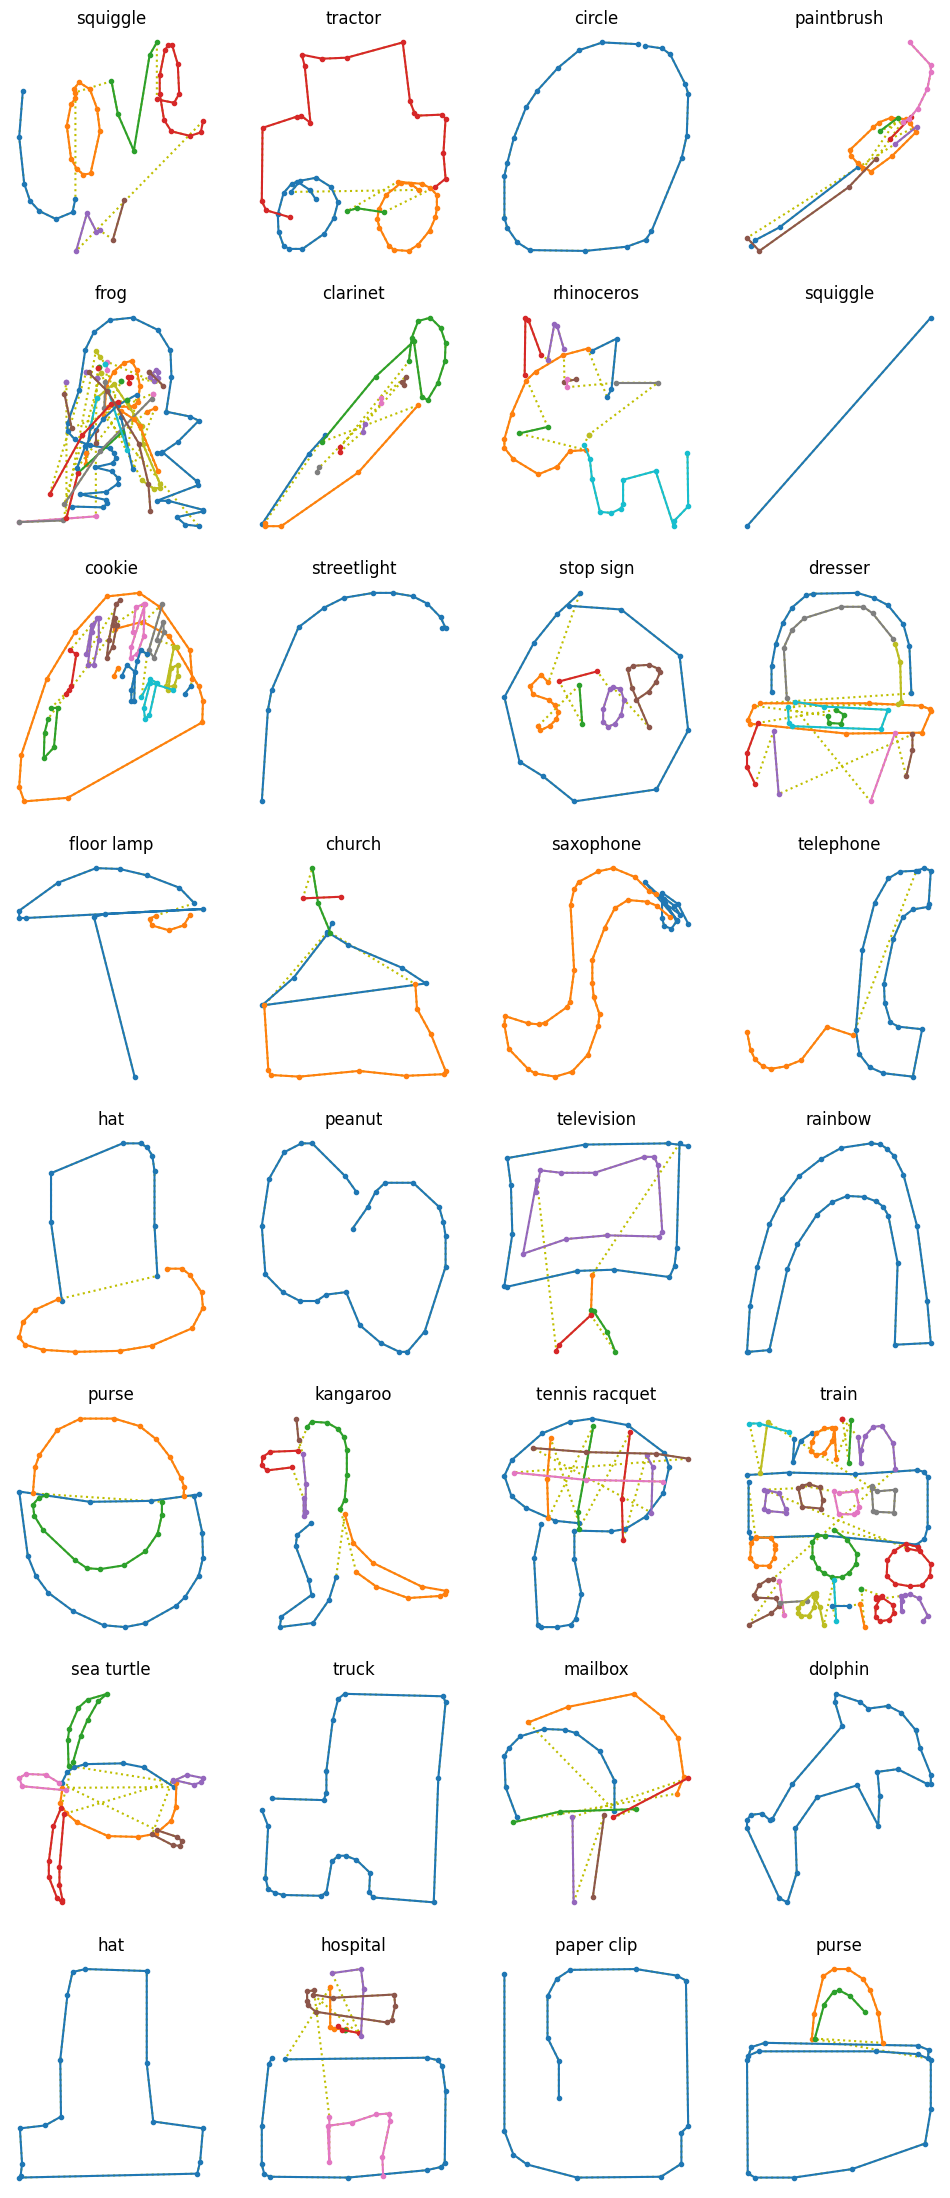

In [95]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

Most sketches are composed of less than 100 points:

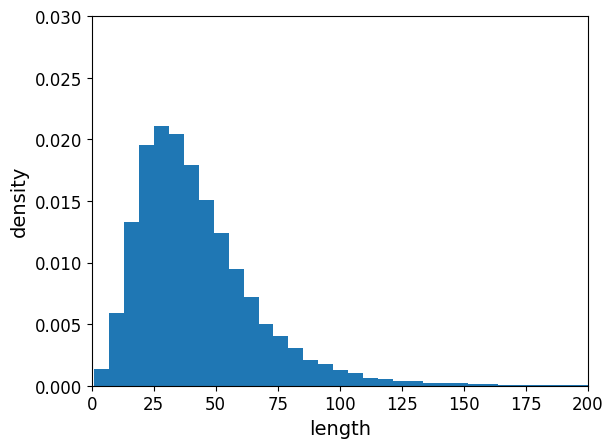

In [96]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [97]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [98]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
 107813/Unknown 1068s 10ms/step - accuracy: 0.0847 - loss: 4.8136 - sparse_top_k_categorical_accuracy: 0.2139

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


107813/107813 ━━━━━━━━━━━━━━━━━━━━ 1090s 10ms/step - accuracy: 0.0847 - loss: 4.8136 - sparse_top_k_categorical_accuracy: 0.2140 - val_accuracy: 0.3222 - val_loss: 3.0245 - val_sparse_top_k_categorical_accuracy: 0.6054
Epoch 2/2
107813/107813 ━━━━━━━━━━━━━━━━━━━━ 1101s 10ms/step - accuracy: 0.3508 - loss: 2.8580 - sparse_top_k_categorical_accuracy: 0.6389 - val_accuracy: 0.4302 - val_loss: 2.4375 - val_sparse_top_k_categorical_accuracy: 0.7185


In [99]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

5392/5392 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step


In [100]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.5992129

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


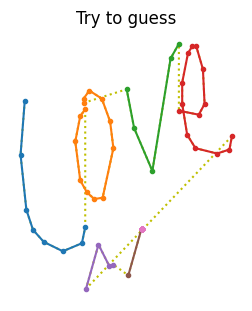

Top-5 predictions:
  1. animal migration 26.372%
  2. ant 11.716%
  3. mosquito 7.330%
  4. fork 6.083%
  5. bird 4.042%
Answer: squiggle


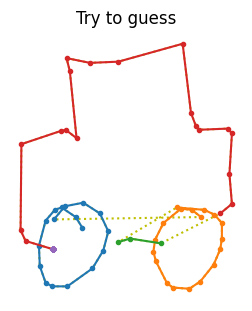

Top-5 predictions:
  1. motorbike 37.056%
  2. police car 13.668%
  3. bicycle 10.421%
  4. tractor 9.106%
  5. car 6.030%
Answer: tractor


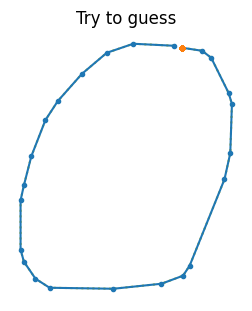

Top-5 predictions:
  1. pond 13.002%
  2. hexagon 12.534%
  3. octagon 10.925%
  4. nose 7.828%
  5. pear 6.146%
Answer: circle


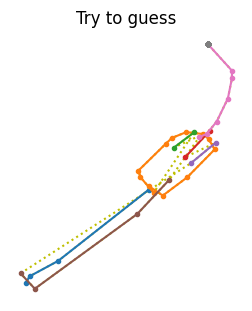

Top-5 predictions:
  1. syringe 16.647%
  2. stitches 13.847%
  3. rake 9.498%
  4. see saw 7.600%
  5. feather 7.019%
Answer: paintbrush


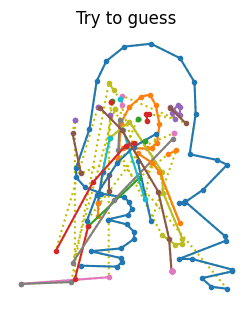

Top-5 predictions:
  1. zebra 8.827%
  2. horse 6.017%
  3. tiger 4.570%
  4. broccoli 4.470%
  5. camouflage 3.043%
Answer: frog


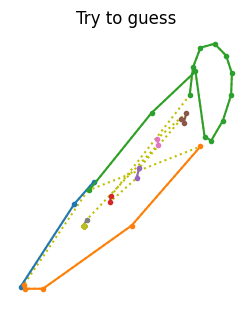

Top-5 predictions:
  1. syringe 11.689%
  2. fork 9.736%
  3. flashlight 9.047%
  4. carrot 7.924%
  5. garden hose 7.385%
Answer: clarinet


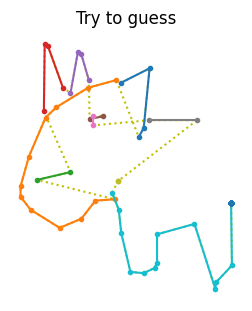

Top-5 predictions:
  1. sun 20.185%
  2. mouse 8.509%
  3. rhinoceros 4.316%
  4. submarine 3.582%
  5. scorpion 3.455%
Answer: rhinoceros


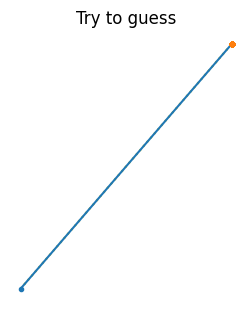

Top-5 predictions:
  1. line 80.827%
  2. rain 1.755%
  3. leg 1.483%
  4. stairs 1.209%
  5. broom 1.180%
Answer: squiggle


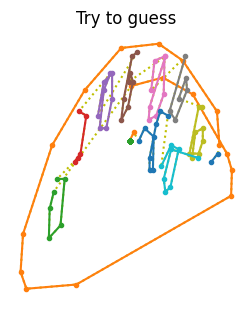

Top-5 predictions:
  1. peas 11.320%
  2. garden 8.719%
  3. submarine 5.057%
  4. brain 5.017%
  5. stop sign 4.788%
Answer: cookie


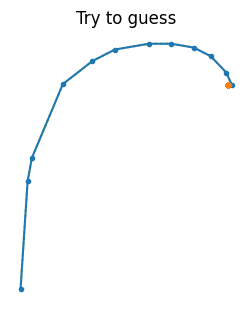

Top-5 predictions:
  1. line 11.064%
  2. stairs 5.206%
  3. rain 3.816%
  4. garden hose 3.693%
  5. finger 3.642%
Answer: streetlight


In [101]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [102]:
model.save("my_sketchrnn")

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=my_sketchrnn.

## 10. Bach Chorales
_Exercise: Download the [Bach chorales](https://homl.info/bach) dataset and unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note's index on a piano (except for the value 0, which means that no note is played). Train a model—recurrent, convolutional, or both—that can predict the next time step (four notes), given a sequence of time steps from a chorale. Then use this model to generate Bach-like music, one note at a time: you can do this by giving the model the start of a chorale and asking it to predict the next time step, then appending these time steps to the input sequence and asking the model for the next note, and so on. Also make sure to check out [Google's Coconet model](https://homl.info/coconet), which was used for a nice [Google doodle about Bach](https://www.google.com/doodles/celebrating-johann-sebastian-bach)._



In [ ]:
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/datasets/jsb_chorales/"
FILENAME = "jsb_chorales.tgz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/jsb_chorales",
                                extract=True)

In [ ]:
jsb_chorales_dir = Path(filepath).parent
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [ ]:
import pandas as pd

def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

In [ ]:
train_chorales[0]

Notes range from 36 (C1 = C on octave 1) to 81 (A5 = A on octave 5), plus 0 for silence:

In [ ]:
notes = set()
for chorales in (train_chorales, valid_chorales, test_chorales):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

assert min_note == 36
assert max_note == 81

Let's write a few functions to listen to these chorales (you don't need to understand the details here, and in fact there are certainly simpler ways to do this, for example using MIDI players, but I just wanted to have a bit of fun writing a synthesizer):

In [ ]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    # Frequency doubles when you go up one octave; there are 12 semi-tones
    # per octave; Note A on octave 4 is 440 Hz, and it is note number 69.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # the tempo is measured in beats per minutes
    # To reduce click sound at every beat, we round the frequencies to try to
    # get the samples close to zero at the end of each note.
    frequencies = np.round(note_duration * frequencies) / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # Removing all notes with frequencies ≤ 9 Hz (includes note 0 = silence)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]] # make last note a bit longer
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo # fade out last note
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

Now let's listen to a few chorales:

In [ ]:
for index in range(3):
    play_chords(train_chorales[index])

Divine! :)

In order to be able to generate new chorales, we want to train a model that can predict the next chord given all the previous chords. If we naively try to predict the next chord in one shot, predicting all 4 notes at once, we run the risk of getting notes that don't go very well together (believe me, I tried). It's much better and simpler to predict one note at a time. So we will need to preprocess every chorale, turning each chord into an arpegio (i.e., a sequence of notes rather than notes played simultaneuously). So each chorale will be a long sequence of notes (rather than chords), and we can just train a model that can predict the next note given all the previous notes. We will use a sequence-to-sequence approach, where we feed a window to the neural net, and it tries to predict that same window shifted one time step into the future.

We will also shift the values so that they range from 0 to 46, where 0 represents silence, and values 1 to 46 represent notes 36 (C1) to 81 (A5).

And we will train the model on windows of 128 notes (i.e., 32 chords).

Since the dataset fits in memory, we could preprocess the chorales in RAM using any Python code we like, but I will demonstrate here how to do all the preprocessing using tf.data (there will be more details about creating windows using tf.data in the next chapter).

In [ ]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:] # predict next note in each arpegio, at each step
    return X, Y

def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1) # shift values
    return tf.reshape(window, [-1]) # convert to arpegio

def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

Now let's create the training set, the validation set and the test set:

In [ ]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales)
test_set = bach_dataset(test_chorales)

Now let's create the model:

* We could feed the note values directly to the model, as floats, but this would probably not give good results. Indeed, the relationships between notes are not that simple: for example, if you replace a C3 with a C4, the melody will still sound fine, even though these notes are 12 semi-tones apart (i.e., one octave). Conversely, if you replace a C3 with a C\#3, it's very likely that the chord will sound horrible, despite these notes being just next to each other. So we will use an `Embedding` layer to convert each note to a small vector representation (see Chapter 16 for more details on embeddings). We will use 5-dimensional embeddings, so the output of this first layer will have a shape of `[batch_size, window_size, 5]`.
* We will then feed this data to a small WaveNet-like neural network, composed of a stack of 4 `Conv1D` layers with doubling dilation rates. We will intersperse these layers with `BatchNormalization` layers for faster better convergence.
* Then one `LSTM` layer to try to capture long-term patterns.
* And finally a `Dense` layer to produce the final note probabilities. It will predict one probability for each chorale in the batch, for each time step, and for each possible note (including silence). So the output shape will be `[batch_size, window_size, 47]`.

In [ ]:
n_embedding_dims = 5

model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.Dense(n_notes, activation="softmax")
])

model.summary()

Now we're ready to compile and train the model!

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.fit(train_set, epochs=20, validation_data=valid_set)

I have not done much hyperparameter search, so feel free to iterate on this model now and try to optimize it. For example, you could try removing the `LSTM` layer and replacing it with `Conv1D` layers. You could also play with the number of layers, the learning rate, the optimizer, and so on.

Once you're satisfied with the performance of the model on the validation set, you can save it and evaluate it one last time on the test set:

In [ ]:
model.save("my_bach_model.h5")
model.evaluate(test_set)

**Note:** There's no real need for a test set in this exercise, since we will perform the final evaluation by just listening to the music produced by the model. So if you want, you can add the test set to the train set, and train the model again, hopefully getting a slightly better model.

Now let's write a function that will generate a new chorale. We will give it a few seed chords, it will convert them to arpegios (the format expected by the model), and use the model to predict the next note, then the next, and so on. In the end, it will group the notes 4 by 4 to create chords again, and return the resulting chorale.

In [ ]:
def generate_chorale(model, seed_chords, length):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note = model.predict_classes(arpegio)[:1, -1:]
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

To test this function, we need some seed chords. Let's use the first 8 chords of one of the test chorales (it's actually just 2 different chords, each played 4 times):

In [ ]:
seed_chords = test_chorales[2][:8]
play_chords(seed_chords, amplitude=0.2)

Now we are ready to generate our first chorale! Let's ask the function to generate 56 more chords, for a total of 64 chords, i.e., 16 bars (assuming 4 chords per bar, i.e., a 4/4 signature):

In [ ]:
new_chorale = generate_chorale(model, seed_chords, 56)
play_chords(new_chorale)

This approach has one major flaw: it is often too conservative. Indeed, the model will not take any risk, it will always choose the note with the highest score, and since repeating the previous note generally sounds good enough, it's the least risky option, so the algorithm will tend to make notes last longer and longer. Pretty boring. Plus, if you run the model multiple times, it will always generate the same melody.

So let's spice things up a bit! Instead of always picking the note with the highest score, we will pick the next note randomly, according to the predicted probabilities. For example, if the model predicts a C3 with 75% probability, and a G3 with a 25% probability, then we will pick one of these two notes randomly, with these probabilities. We will also add a `temperature` parameter that will control how "hot" (i.e., daring) we want the system to feel. A high temperature will bring the predicted probabilities closer together, reducing the probability of the likely notes and increasing the probability of the unlikely ones.

In [ ]:
def generate_chorale_v2(model, seed_chords, length, temperature=1):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note_probas = model.predict(arpegio)[0, -1:]
            rescaled_logits = tf.math.log(next_note_probas) / temperature
            next_note = tf.random.categorical(rescaled_logits, num_samples=1)
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

Let's generate 3 chorales using this new function: one cold, one medium, and one hot (feel free to experiment with other seeds, lengths and temperatures). The code saves each chorale to a separate file. You can run these cells over an over again until you generate a masterpiece!

**Please share your most beautiful generated chorale with me on Twitter @aureliengeron, I would really appreciate it! :))**

In [ ]:
new_chorale_v2_cold = generate_chorale_v2(model, seed_chords, 56, temperature=0.8)
play_chords(new_chorale_v2_cold, filepath="bach_cold.wav")

In [ ]:
new_chorale_v2_medium = generate_chorale_v2(model, seed_chords, 56, temperature=1.0)
play_chords(new_chorale_v2_medium, filepath="bach_medium.wav")

In [ ]:
new_chorale_v2_hot = generate_chorale_v2(model, seed_chords, 56, temperature=1.5)
play_chords(new_chorale_v2_hot, filepath="bach_hot.wav")

Lastly, you can try a fun social experiment: send your friends a few of your favorite generated chorales, plus the real chorale, and ask them to guess which one is the real one!

In [ ]:
play_chords(test_chorales[2][:64], filepath="bach_test_4.wav")